<a href="https://colab.research.google.com/github/odarrieta/odarrieta/blob/main/Comparaci%C3%B3n_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparación diferentes algoritmos (Classifiers)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn


In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Cargar los datos
survey_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hachathon/Surveydata_train.csv')
travel_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hachathon/Traveldata_train.csv')
survey_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hachathon/Surveydata_test.csv')
travel_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Hachathon/Traveldata_test.csv')

train_data = pd.merge(survey_train, travel_train, on='ID')
test_data = pd.merge(survey_test, travel_test, on='ID')

# Preprocesamiento
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.drop('Overall_Experience')
cat_cols = train_data.select_dtypes(include=['object']).columns

# Imputar valores faltantes
train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
test_data[num_cols] = num_imputer.transform(test_data[num_cols])
test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])

# Codificar variables categóricas
class CustomLabelEncoder:
    def __init__(self):
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    def fit(self, data):
        self.encoder.fit(data)

    def transform(self, data):
        return self.encoder.transform(data)

    def fit_transform(self, data):
        self.encoder.fit(data)
        return self.encoder.transform(data)

custom_encoders = {}
for col in cat_cols:
    custom_encoders[col] = CustomLabelEncoder()
    train_data[col] = custom_encoders[col].fit_transform(train_data[[col]])
    test_data[col] = custom_encoders[col].transform(test_data[[col]])

# Escalar características numéricas
scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])

# Dividir los datos en conjuntos de entrenamiento y validación
X = train_data.drop(columns=['Overall_Experience', 'ID'])
y = train_data['Overall_Experience']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression - AUC: 0.8153882872221065
Confusion Matrix:
[[5763 2642]
 [2051 8420]]

Random Forest - AUC: 0.989148727305596
Confusion Matrix:
[[7950  455]
 [ 564 9907]]

Gradient Boosting - AUC: 0.9780330150108361
Confusion Matrix:
[[7632  773]
 [ 685 9786]]



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:44:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - AUC: 0.9927383644956688
Confusion Matrix:
[[8011  394]
 [ 493 9978]]

Support Vector Machine - AUC: 0.9710734858139967
Confusion Matrix:
[[7488  917]
 [ 709 9762]]



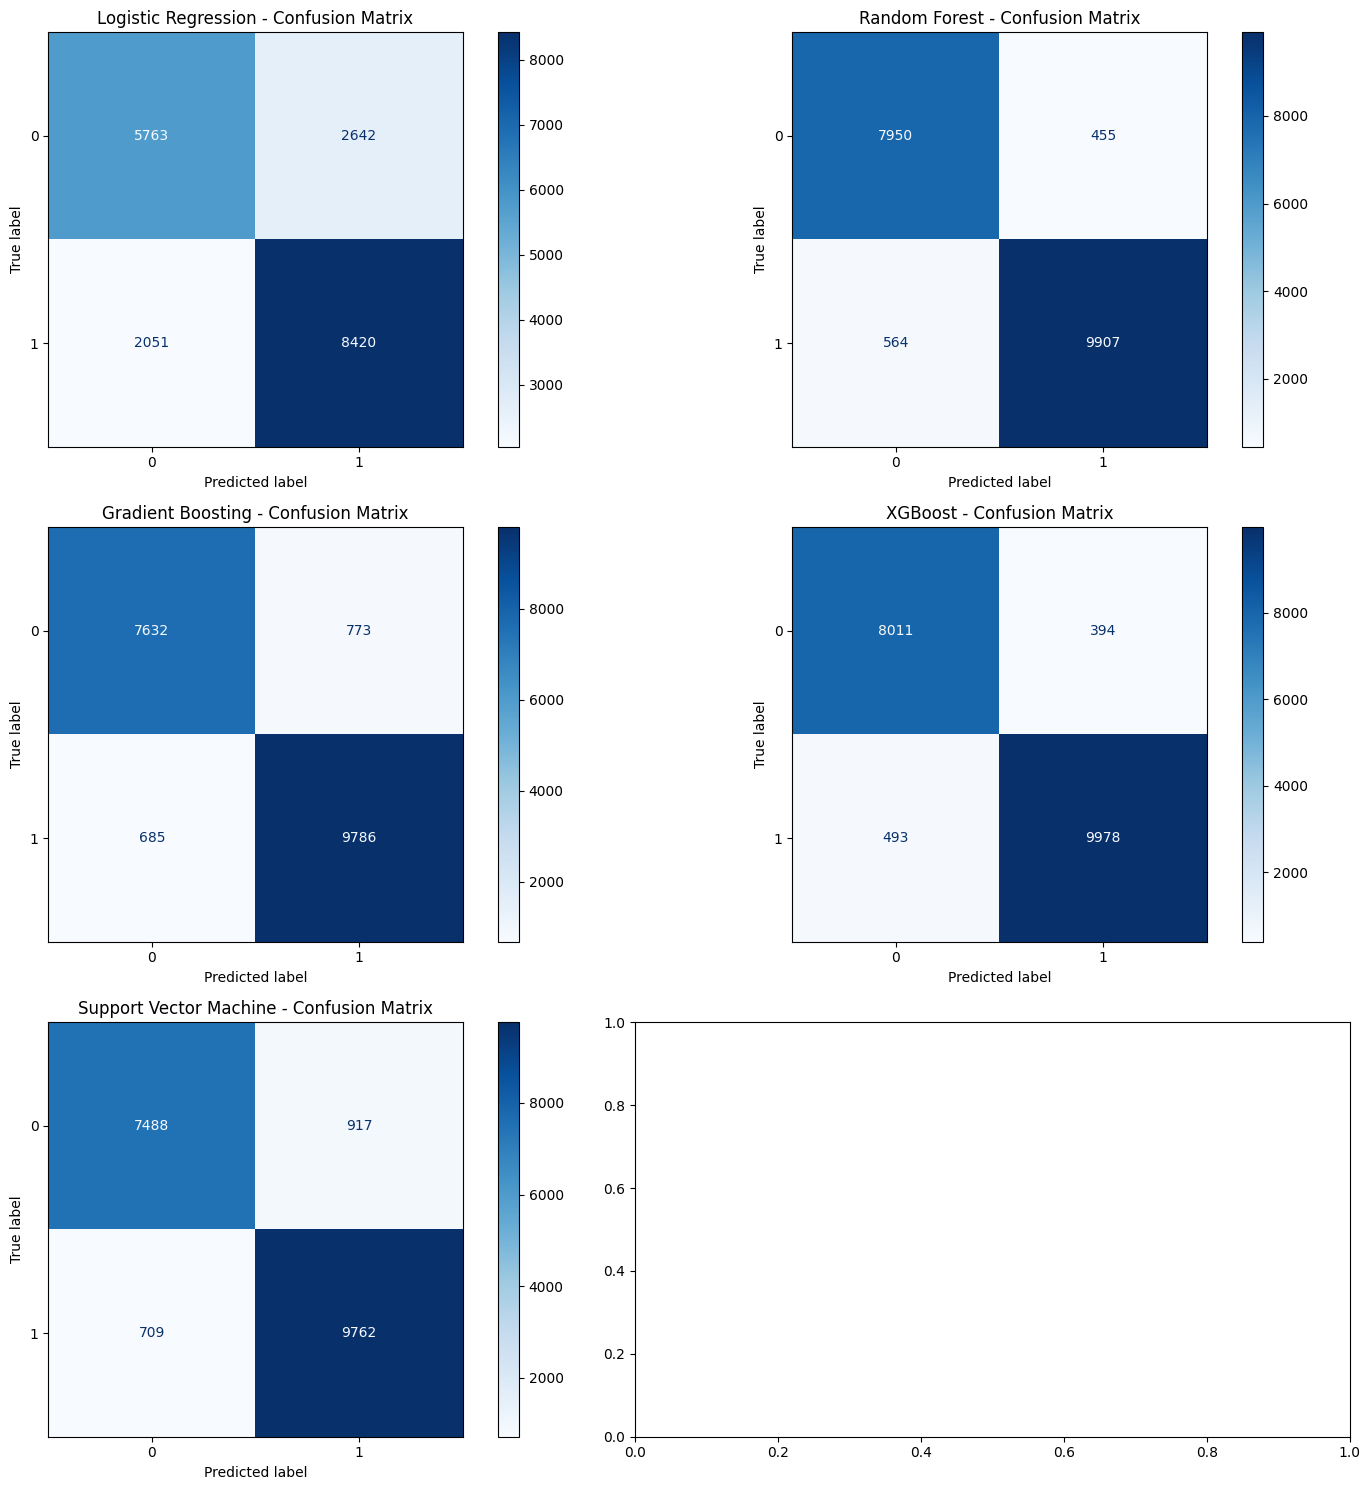

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Lista de clasificadores
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

results = {}

# Entrenar y evaluar cada clasificador
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    conf_matrix = confusion_matrix(y_val, y_pred)

    results[name] = {'AUC': auc_score, 'Confusion Matrix': conf_matrix}
    print(f"{name} - AUC: {auc_score}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

# Visualizar la matriz de confusión para cada modelo
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=result['Confusion Matrix'], display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{name} - Confusion Matrix")

plt.tight_layout()
plt.show()

# Usar el mejor modelo (XG Boost) y tuning de hiperparámetros

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best XGBoost AUC: 0.9928510180606464


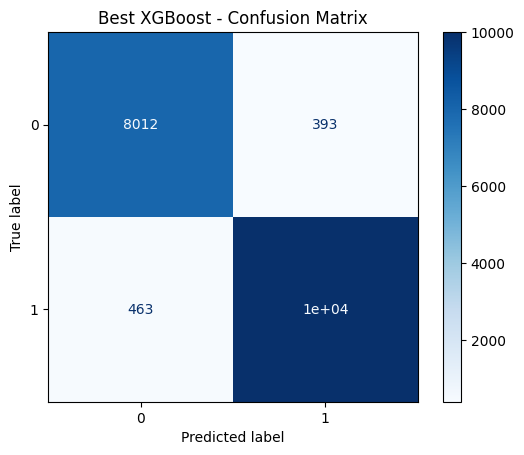

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Crear el clasificador XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Ejecutar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros
best_xgb = random_search.best_estimator_
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"Best XGBoost AUC: {auc_score}")

# Mostrar la matriz de confusión del mejor modelo
conf_matrix = confusion_matrix(y_val, best_xgb.predict(X_val))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f"Best XGBoost - Confusion Matrix")
plt.show()


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2187 fits failed out of a total of 6561.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2187 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.p

Best parameters found after refinement: {'colsample_bytree': 0.81, 'gamma': 0.30000000000000004, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 6, 'n_estimators': 250, 'subsample': 1.0}
Refined XGBoost AUC: 0.9932222708979351


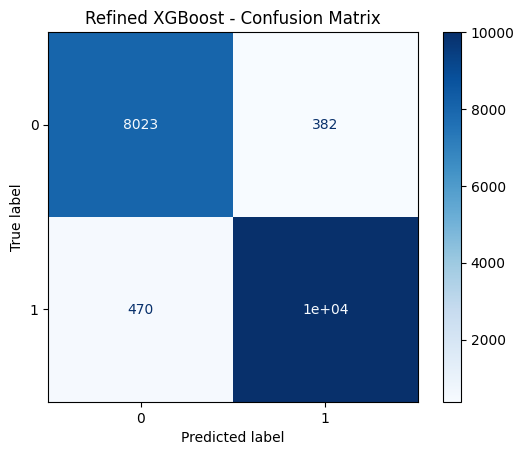

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Mejor hiperparámetro encontrado en la búsqueda anterior
best_params = random_search.best_params_

# Definir un espacio de búsqueda más estrecho alrededor de los mejores hiperparámetros
param_grid = {
    'learning_rate': [best_params['learning_rate'] * factor for factor in [0.5, 1.0, 1.5]],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'min_child_weight': [best_params['min_child_weight'] - 1, best_params['min_child_weight'], best_params['min_child_weight'] + 1],
    'gamma': [best_params['gamma'] * factor for factor in [0.5, 1.0, 1.5]],
    'subsample': [best_params['subsample'] * factor for factor in [0.9, 1.0, 1.1]],
    'colsample_bytree': [best_params['colsample_bytree'] * factor for factor in [0.9, 1.0, 1.1]]
}

# Crear el clasificador XGBoost con los mejores parámetros encontrados previamente
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Best parameters found after refinement: {grid_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros refinados
best_xgb_refined = grid_search.best_estimator_
y_pred_proba = best_xgb_refined.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"Refined XGBoost AUC: {auc_score}")

# Mostrar la matriz de confusión del mejor modelo refinado
conf_matrix = confusion_matrix(y_val, best_xgb_refined.predict(X_val))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f"Refined XGBoost - Confusion Matrix")
plt.show()
